In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [6]:
bf = pd.read_csv('BlackFriday.csv')
bf.shape[0]

537577

# Exploring the Data

The data set I've chosen to examine was pulled off Kaggle, and contains a sample of purchases made by consumers in a retail store during Black Friday. The data set is hypothetical, and engineered with modeling in mind. We have several features related to the customer, including: Gender, Age, Occupation, Marital Status, what type of city they live in, and how long they have been living in that city. We also have some features related to the product they purchased: category the item falls under, and two subcategories to further classify the item. Finally, we have the total amount (in USD) spent on the consumer's Black Friday purchase. This data set is convenient to work with because it provides us with a number of categorical features to use in a regression to predict the total amount spent. Conversely, we can select any of those categorical features as our target variable and run a classifying model for predictions.

First things first, however, let's take a look at the data set and see if there's anything we need to clean up.

In [7]:
nullcount = bf.isnull().sum()
print(nullcount[nullcount>0])

print(nullcount['Product_Category_2'] / bf.shape[0])
print(nullcount['Product_Category_3'] / bf.shape[0])

Product_Category_2    166986
Product_Category_3    373299
dtype: int64
0.3106271287648095
0.6944102891306734


Nearly 70% of Product Category 3 is null, so we can safely drop that feature from our data set entirely. Only 31% of Product Category 2 is null, so we'll simply drop those rows from our data set and we should still have a robust data set to work with.

In [8]:
list(bf.columns)

['User_ID',
 'Product_ID',
 'Gender',
 'Age',
 'Occupation',
 'City_Category',
 'Stay_In_Current_City_Years',
 'Marital_Status',
 'Product_Category_1',
 'Product_Category_2',
 'Product_Category_3',
 'Purchase']

In [9]:
print('Unique User IDs:', len(bf['User_ID'].value_counts()))
print('Unique Product IDs:', len(bf['Product_ID'].value_counts()))

Unique User IDs: 5891
Unique Product IDs: 3623


Taking a look at our other columns, User_ID and Product_ID both have a high number of unique values that we cannot feasibly generate dummies for, so we will exclude them from our data set.

In [10]:
bf = bf.drop(['User_ID', 'Product_ID', 'Product_Category_3'], axis=1)
bf = bf.dropna()
bf.shape[0]

370591

After cleaning up our data we still have over 300k entries, retaining ~70% of our original data set. Now that we've dealt with the null entries, we can clean up the rest of the features - starting with changing gender into a binary (in this case, we'll have Male = 1 and Female = 0).

In [11]:
gender_bin = []

for i in bf['Gender']:
    if i == 'M':
        gender_bin.append(1)
    else:
        gender_bin.append(0)
        
bf['Gender'] = gender_bin

And more for visual appeal than anything else, we'll convert all numeric values in the Product Category features to integer instead of a mix of integers and floats.

In [12]:
for col in ['Product_Category_1', 'Product_Category_2']:
    bf[col] = bf[col].astype('int64')

Because the Occupation and Product Category features can be more appropriately described as categorical, we'll force their data type to be such.

In [13]:
for col in ['Occupation', 'Product_Category_1', 'Product_Category_2']:
    bf[col] = bf[col].astype('category')

And finally, we'll get dummies for each of our categorical variables - giving us the data frame that we'll use for analysis.

In [14]:
bfd = pd.get_dummies(bf)

# Visualizing the Data

Now that we've got things formatted nicely to plug into our modeleling techniques, lets first take a look at what the features look like as is.

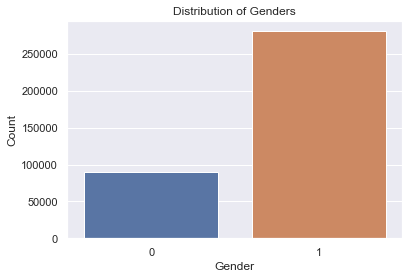

In [15]:
sns.set(style='darkgrid')
sns.countplot(x='Gender', data=bf)
plt.ylabel('Count')
plt.title('Distribution of Genders')
plt.show()

In our sample of Black Friday shoppers, it seems that male shoppers are represented much more than female.

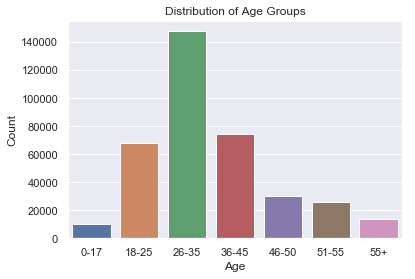

In [16]:
sns.countplot('Age', data=bf, order=['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'])
plt.ylabel('Count')
plt.title('Distribution of Age Groups')
plt.show()

Similarly to gender, the 26-35 age group is represented heavily - though our distribution of ages is something close to normal.

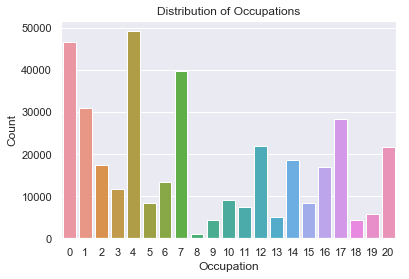

In [17]:
sns.countplot('Occupation', data=bf)
plt.ylabel('Count')
plt.title('Distribution of Occupations')
plt.show()

Occupations to look out for here are the ones coded for 0, 4, and 7. The specifics of the code are not shared, because the data set was a hypothetical one.

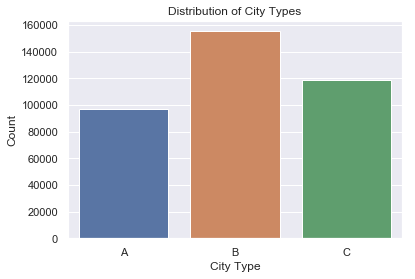

In [18]:
sns.countplot('City_Category', data=bf)
plt.ylabel('Count')
plt.xlabel('City Type')
plt.title('Distribution of City Types')
plt.show()

Again, the specifics of the code are not presented since the data set is not based off a real life situation - but we have folks from City Type B being heavily represented.

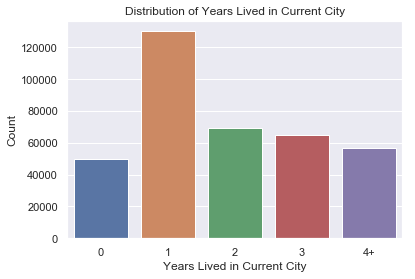

In [19]:
sns.countplot('Stay_In_Current_City_Years', data=bf, order=('0', '1', '2', '3', '4+'))
plt.xlabel('Years Lived in Current City')
plt.ylabel('Count')
plt.title('Distribution of Years Lived in Current City')
plt.show()

Most folks who shopped at this particular retail chain on Black Friday have only been living in their particular city for a year.

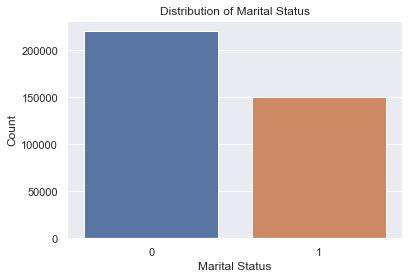

In [20]:
sns.countplot('Marital_Status', data=bf)
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Distribution of Marital Status')
plt.show()

More folks are single than married in our data set.

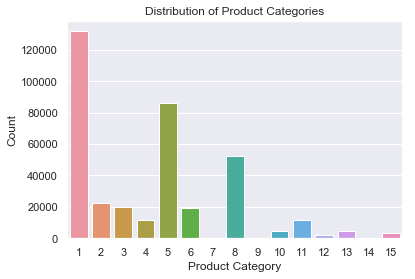

In [21]:
sns.countplot('Product_Category_1', data=bf)
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.title('Distribution of Product Categories')
plt.show()

The most common category for the products are 1, 5, and 8.

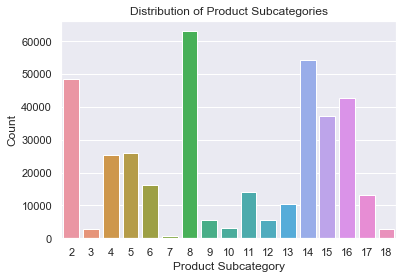

In [22]:
sns.countplot('Product_Category_2', data=bf)
plt.xlabel('Product Subcategory')
plt.ylabel('Count')
plt.title('Distribution of Product Subcategories')
plt.show()

The most prevalent subcategories are 2, 8, 14, 15, and 16.

Now that we've gotten to take a look at each of our individual features, let's see how they relate to our first target variable of interest: Purchase.

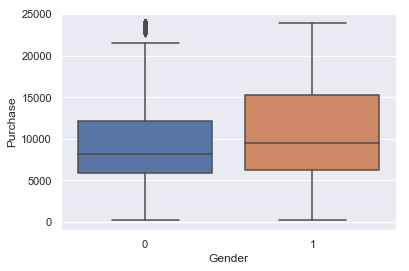

In [23]:
sns.boxplot(x='Gender', y='Purchase', data=bf)
plt.show()

Despite there being many more males than females in our data set, the cost of their Black Friday purchases is relatively similar. There do appear to be a few outliers in the females that we should keep an eye on, however.

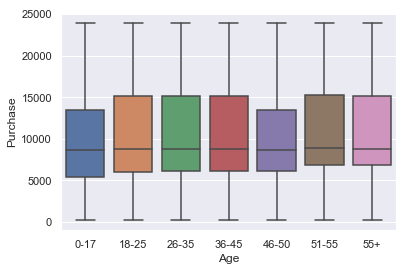

In [24]:
sns.boxplot(x='Age', y='Purchase', data=bf, order=['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'])
plt.show()

All age demographics are well represented, though it would seem that all ages are buying items on Black Friday that cost roughly the same amount.

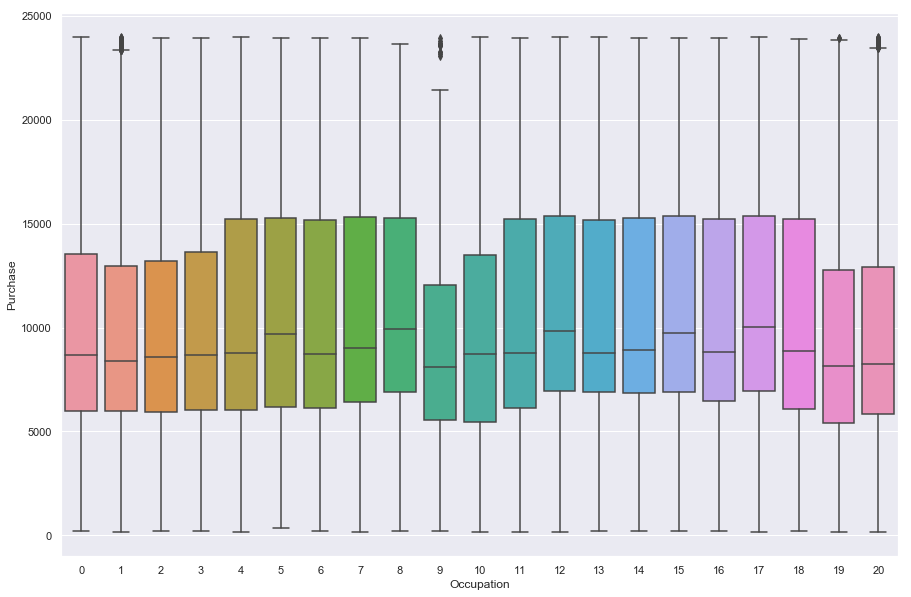

In [25]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot('Occupation', 'Purchase', data=bf)
plt.show()

Similar to age, it would seem that the occupation doesn't affect purchase price as much. Though there is some variation that we can keep an eye on.

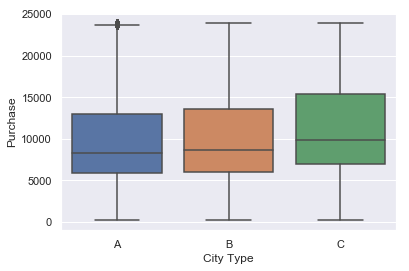

In [26]:
sns.boxplot('City_Category', 'Purchase', data=bf)
plt.xlabel('City Type')
plt.show()

City has some variation we can look more closely at.

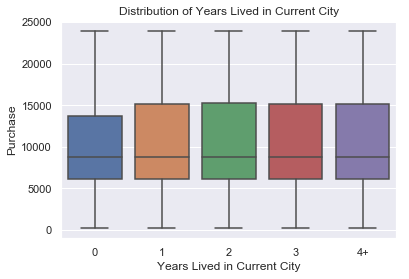

In [27]:
sns.boxplot('Stay_In_Current_City_Years', 'Purchase', data=bf, order=('0', '1', '2', '3', '4+'))
plt.xlabel('Years Lived in Current City')
plt.title('Distribution of Years Lived in Current City')
plt.show()

Though it would seem how long you live in your current city doesn't affect how big of a purchase you're making!

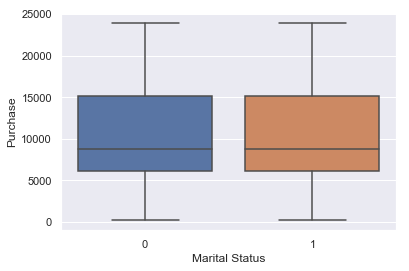

In [28]:
sns.boxplot('Marital_Status', 'Purchase', data=bf)
plt.xlabel('Marital Status')
plt.show()

Marital status doesn't have much of an effect on purchase either.

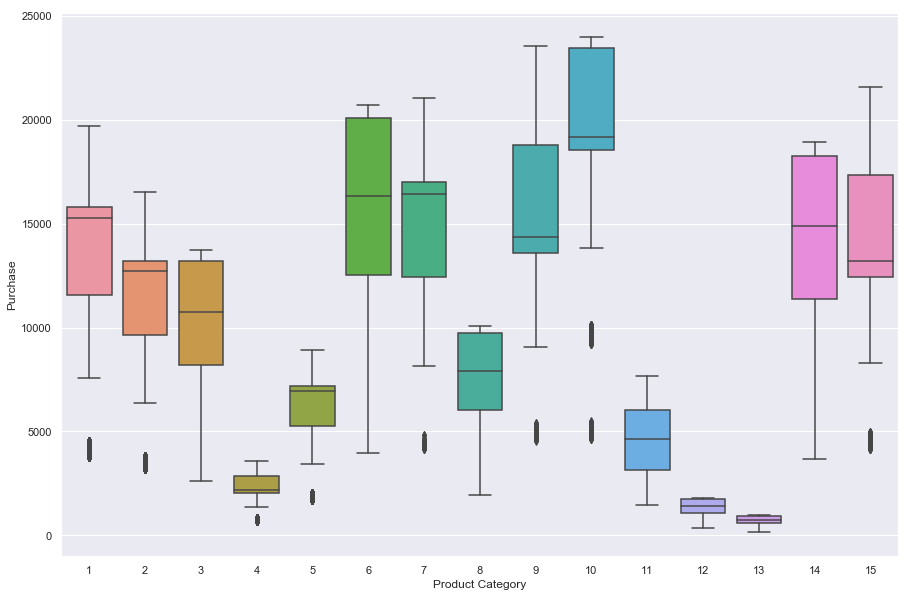

In [29]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot('Product_Category_1', 'Purchase', data=bf)
plt.xlabel('Product Category')
plt.show()

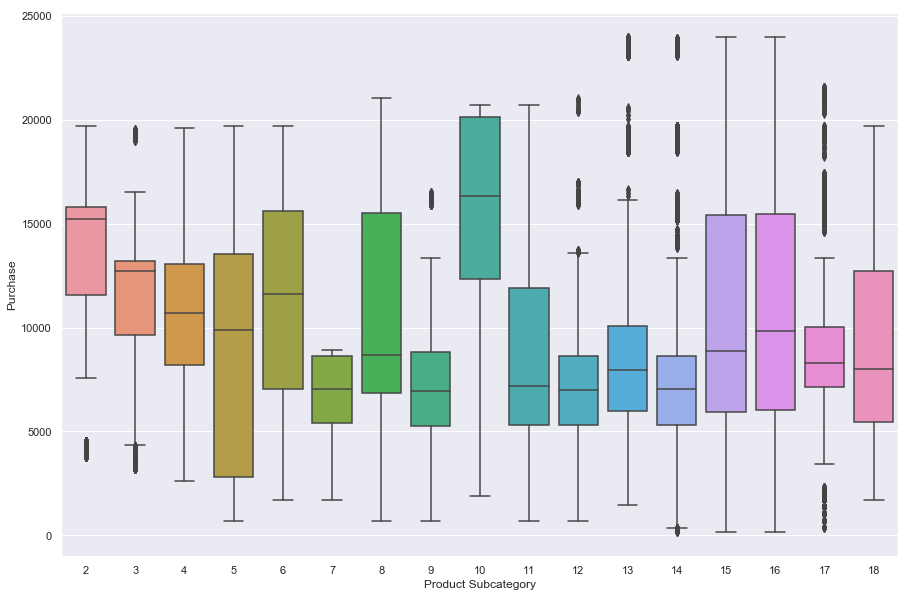

In [30]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot('Product_Category_2', 'Purchase', data=bf)
plt.xlabel('Product Subcategory')
plt.show()

As one might expect, which product your purchasing has a great deal to do with how much it costs. These features will contain a lot of explanatory power for our models, though there are some concerning outliers which we'll need to keep in mind.

# Modeling the Data: Regression

Now that we've taken a look at all of our features individually, let's take a preliminary stab at modeling the data. Since our target variable is purchase price, we'll utilize the regression models available to us and test each one.

## Cleaning up the Data

First things first - based on our visualizations, our model has quite a few features that aren't correlated to our target variable much if at all. So we first take a look at some correlation matrices to see what we can remove right off the bat.

In [31]:
list(bfd.columns)

['Gender',
 'Marital_Status',
 'Purchase',
 'Age_0-17',
 'Age_18-25',
 'Age_26-35',
 'Age_36-45',
 'Age_46-50',
 'Age_51-55',
 'Age_55+',
 'Occupation_0',
 'Occupation_1',
 'Occupation_2',
 'Occupation_3',
 'Occupation_4',
 'Occupation_5',
 'Occupation_6',
 'Occupation_7',
 'Occupation_8',
 'Occupation_9',
 'Occupation_10',
 'Occupation_11',
 'Occupation_12',
 'Occupation_13',
 'Occupation_14',
 'Occupation_15',
 'Occupation_16',
 'Occupation_17',
 'Occupation_18',
 'Occupation_19',
 'Occupation_20',
 'City_Category_A',
 'City_Category_B',
 'City_Category_C',
 'Stay_In_Current_City_Years_0',
 'Stay_In_Current_City_Years_1',
 'Stay_In_Current_City_Years_2',
 'Stay_In_Current_City_Years_3',
 'Stay_In_Current_City_Years_4+',
 'Product_Category_1_1',
 'Product_Category_1_2',
 'Product_Category_1_3',
 'Product_Category_1_4',
 'Product_Category_1_5',
 'Product_Category_1_6',
 'Product_Category_1_7',
 'Product_Category_1_8',
 'Product_Category_1_9',
 'Product_Category_1_10',
 'Product_Categor

In [32]:
split1 = bfd.loc[:, ['Gender','Marital_Status','Age_0-17','Age_18-25','Age_26-35','Age_36-45','Age_46-50','Age_51-55','Age_55+']]
split1['Purchase'] = bfd['Purchase']
split1.corr()

,Gender,Marital_Status,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Purchase
Gender,1.000000,-0.009450,-0.039699,-0.001093,0.034706,-0.003961,-0.029777,-0.003390,0.003313,0.076227
Marital_Status,-0.009450,1.000000,-0.140787,-0.190656,-0.024067,-0.013857,0.195990,0.174748,0.086348,-0.000812
Age_0-17,-0.039699,-0.140787,1.000000,-0.081001,-0.138809,-0.085275,-0.050999,-0.046489,-0.033605,-0.013233
Age_18-25,-0.001093,-0.190656,-0.081001,1.000000,-0.386883,-0.237674,-0.142141,-0.129573,-0.093663,-0.003972
Age_26-35,0.034706,-0.024067,-0.138809,-0.386883,1.000000,-0.407296,-0.243584,-0.222046,-0.160508,-0.000408
Age_36-45,-0.003961,-0.013857,-0.085275,-0.237674,-0.407296,1.000000,-0.149641,-0.136410,-0.098605,0.004121
Age_46-50,-0.029777,0.195990,-0.050999,-0.142141,-0.243584,-0.149641,1.000000,-0.081580,-0.058971,-0.007449
Age_51-55,-0.003390,0.174748,-0.046489,-0.129573,-0.222046,-0.136410,-0.081580,1.000000,-0.053757,0.013797
Age_55+,0.003313,0.086348,-0.033605,-0.093663,-0.160508,-0.098605,-0.058971,-0.053757,1.000000,0.004355
Purchase,0.076227,-0.000812,-0.013233,-0.003972,-0.000408,0.004121,-0.007449,0.013797,0.004355,1.000000


As we suspected from our boxplots, none of these features are particularly well correlated with purchase amount and can be dropped.

In [33]:
split2 = bfd.loc[:, [ 'Occupation_0','Occupation_1','Occupation_2','Occupation_3','Occupation_4','Occupation_5','Occupation_6','Occupation_7','Occupation_8','Occupation_9','Occupation_10','Occupation_11','Occupation_12','Occupation_13','Occupation_14','Occupation_15','Occupation_16','Occupation_17','Occupation_18','Occupation_19','Occupation_20',]]
split2['Purchase'] = bfd['Purchase']
split2.corr()

,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,...,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,Purchase
Occupation_0,1.000000,-0.114584,-0.084034,-0.068811,-0.148545,-0.057543,-0.073223,-0.131546,-0.020867,-0.041606,...,-0.095092,-0.044163,-0.087521,-0.057649,-0.083037,-0.109417,-0.041597,-0.047350,-0.094694,-0.012168
Occupation_1,-0.114584,1.000000,-0.066851,-0.054741,-0.118171,-0.045777,-0.058251,-0.104648,-0.016601,-0.033099,...,-0.075648,-0.035132,-0.069625,-0.045861,-0.066058,-0.087044,-0.033091,-0.037668,-0.075331,-0.023572
Occupation_2,-0.084034,-0.066851,1.000000,-0.040146,-0.086665,-0.033572,-0.042720,-0.076747,-0.012175,-0.024274,...,-0.055479,-0.025766,-0.051062,-0.033634,-0.048446,-0.063836,-0.024268,-0.027625,-0.055247,-0.014359
Occupation_3,-0.068811,-0.054741,-0.040146,1.000000,-0.070966,-0.027491,-0.034982,-0.062844,-0.009969,-0.019877,...,-0.045429,-0.021098,-0.041812,-0.027541,-0.039670,-0.052272,-0.019872,-0.022621,-0.045239,-0.004522
Occupation_4,-0.148545,-0.118171,-0.086665,-0.070966,1.000000,-0.059345,-0.075516,-0.135664,-0.021521,-0.042909,...,-0.098069,-0.045545,-0.090261,-0.059454,-0.085636,-0.112842,-0.042899,-0.048832,-0.097659,-0.001745
Occupation_5,-0.057543,-0.045777,-0.033572,-0.027491,-0.059345,1.000000,-0.029253,-0.052553,-0.008337,-0.016622,...,-0.037990,-0.017643,-0.034965,-0.023031,-0.033174,-0.043713,-0.016618,-0.018916,-0.037831,0.006912
Occupation_6,-0.073223,-0.058251,-0.042720,-0.034982,-0.075516,-0.029253,1.000000,-0.066874,-0.010608,-0.021151,...,-0.048342,-0.022451,-0.044493,-0.029307,-0.042213,-0.055624,-0.021146,-0.024071,-0.048140,-0.001558
Occupation_7,-0.131546,-0.104648,-0.076747,-0.062844,-0.135664,-0.052553,-0.066874,1.000000,-0.019058,-0.037998,...,-0.086846,-0.040333,-0.079931,-0.052650,-0.075836,-0.099928,-0.037989,-0.043244,-0.086482,0.015262
Occupation_8,-0.020867,-0.016601,-0.012175,-0.009969,-0.021521,-0.008337,-0.010608,-0.019058,1.000000,-0.006028,...,-0.013777,-0.006398,-0.012680,-0.008352,-0.012030,-0.015852,-0.006026,-0.006860,-0.013719,0.002859
Occupation_9,-0.041606,-0.033099,-0.024274,-0.019877,-0.042909,-0.016622,-0.021151,-0.037998,-0.006028,1.000000,...,-0.027468,-0.012757,-0.025281,-0.016653,-0.023986,-0.031606,-0.012016,-0.013677,-0.027353,-0.018107


Also as our boxplots suggested, occupation seems to not be correlated at all with purchase amount. These features can be dropped as well.

In [34]:
split3 = bfd.loc[:, ['City_Category_A','City_Category_B','City_Category_C','Stay_In_Current_City_Years_0','Stay_In_Current_City_Years_1','Stay_In_Current_City_Years_2','Stay_In_Current_City_Years_3','Stay_In_Current_City_Years_4+']]
split3['Purchase'] = bfd['Purchase']
split3.corr()

,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Purchase
City_Category_A,1.000000,-0.504707,-0.407764,0.047861,-0.024687,-0.000990,-0.006156,-0.005003,-0.049316
City_Category_B,-0.504707,1.000000,-0.582459,-0.029010,0.016146,-0.009622,0.024978,-0.009862,-0.024205
City_Category_C,-0.407764,-0.582459,1.000000,-0.014382,0.006167,0.011109,-0.020623,0.015141,0.072037
Stay_In_Current_City_Years_0,0.047861,-0.029010,-0.014382,1.000000,-0.289520,-0.188545,-0.181000,-0.167547,-0.006816
Stay_In_Current_City_Years_1,-0.024687,0.016146,0.006167,-0.289520,1.000000,-0.352465,-0.338360,-0.313211,-0.002251
Stay_In_Current_City_Years_2,-0.000990,-0.009622,0.011109,-0.188545,-0.352465,1.000000,-0.220351,-0.203973,0.007465
Stay_In_Current_City_Years_3,-0.006156,0.024978,-0.020623,-0.181000,-0.338360,-0.220351,1.000000,-0.195811,0.000023
Stay_In_Current_City_Years_4+,-0.005003,-0.009862,0.015141,-0.167547,-0.313211,-0.203973,-0.195811,1.000000,0.001331
Purchase,-0.049316,-0.024205,0.072037,-0.006816,-0.002251,0.007465,0.000023,0.001331,1.000000


City info doesn't correlate with purchase amount either.

In [35]:
split4 = bfd.loc[:, [ 'Product_Category_1_1','Product_Category_1_2','Product_Category_1_3','Product_Category_1_4','Product_Category_1_5','Product_Category_1_6','Product_Category_1_7','Product_Category_1_8','Product_Category_1_9','Product_Category_1_10','Product_Category_1_11','Product_Category_1_12','Product_Category_1_13','Product_Category_1_14','Product_Category_1_15']]
split4['Purchase'] = bfd['Purchase']
split4.corr()

,Product_Category_1_1,Product_Category_1_2,Product_Category_1_3,Product_Category_1_4,Product_Category_1_5,Product_Category_1_6,Product_Category_1_7,Product_Category_1_8,Product_Category_1_9,Product_Category_1_10,Product_Category_1_11,Product_Category_1_12,Product_Category_1_13,Product_Category_1_14,Product_Category_1_15,Purchase
Product_Category_1_1,1.000000,-0.189342,-0.175694,-0.132547,-0.407928,-0.173646,-0.021047,-0.301264,-0.024521,-0.083179,-0.134527,-0.056465,-0.085330,-0.024883,-0.071576,0.510326
Product_Category_1_2,-0.189342,1.000000,-0.060232,-0.045440,-0.139846,-0.059530,-0.007215,-0.103280,-0.008406,-0.028516,-0.046119,-0.019357,-0.029253,-0.008531,-0.024538,0.056534
Product_Category_1_3,-0.175694,-0.060232,1.000000,-0.042165,-0.129766,-0.055239,-0.006695,-0.095835,-0.007800,-0.026460,-0.042794,-0.017962,-0.027144,-0.007916,-0.022769,0.000227
Product_Category_1_4,-0.132547,-0.045440,-0.042165,1.000000,-0.097898,-0.041673,-0.005051,-0.072300,-0.005885,-0.019962,-0.032285,-0.013551,-0.020478,-0.005972,-0.017178,-0.266111
Product_Category_1_5,-0.407928,-0.139846,-0.129766,-0.097898,1.000000,-0.128254,-0.015545,-0.222511,-0.018111,-0.061435,-0.099361,-0.041704,-0.063024,-0.018379,-0.052866,-0.395153
Product_Category_1_6,-0.173646,-0.059530,-0.055239,-0.041673,-0.128254,1.000000,-0.006617,-0.094718,-0.007709,-0.026152,-0.042296,-0.017753,-0.026828,-0.007823,-0.022504,0.262744
Product_Category_1_7,-0.021047,-0.007215,-0.006695,-0.005051,-0.015545,-0.006617,1.000000,-0.011481,-0.000934,-0.003170,-0.005127,-0.002152,-0.003252,-0.000948,-0.002728,0.025601
Product_Category_1_8,-0.301264,-0.103280,-0.095835,-0.072300,-0.222511,-0.094718,-0.011481,1.000000,-0.013375,-0.045372,-0.073380,-0.030800,-0.046544,-0.013573,-0.039043,-0.202520
Product_Category_1_9,-0.024521,-0.008406,-0.007800,-0.005885,-0.018111,-0.007709,-0.000934,-0.013375,1.000000,-0.003693,-0.005973,-0.002507,-0.003788,-0.001105,-0.003178,0.034723
Product_Category_1_10,-0.083179,-0.028516,-0.026460,-0.019962,-0.061435,-0.026152,-0.003170,-0.045372,-0.003693,1.000000,-0.020260,-0.008504,-0.012851,-0.003748,-0.010780,0.205936


In [36]:
split5 = bfd.loc[:, [ 'Product_Category_2_2','Product_Category_2_3','Product_Category_2_4','Product_Category_2_5','Product_Category_2_6','Product_Category_2_7','Product_Category_2_8','Product_Category_2_9','Product_Category_2_10','Product_Category_2_11','Product_Category_2_12','Product_Category_2_13','Product_Category_2_14','Product_Category_2_15','Product_Category_2_16','Product_Category_2_17','Product_Category_2_18']]
split5['Purchase'] = bfd['Purchase']
split5.corr()

,Product_Category_2_2,Product_Category_2_3,Product_Category_2_4,Product_Category_2_5,Product_Category_2_6,Product_Category_2_7,Product_Category_2_8,Product_Category_2_9,Product_Category_2_10,Product_Category_2_11,Product_Category_2_12,Product_Category_2_13,Product_Category_2_14,Product_Category_2_15,Product_Category_2_16,Product_Category_2_17,Product_Category_2_18,Purchase
Product_Category_2_2,1.000000,-0.034063,-0.104848,-0.106288,-0.083083,-0.015817,-0.175674,-0.048016,-0.034995,-0.076714,-0.047260,-0.065821,-0.160500,-0.129818,-0.139820,-0.074354,-0.033421,0.265489
Product_Category_2_3,-0.034063,1.000000,-0.023729,-0.024055,-0.018803,-0.003580,-0.039758,-0.010867,-0.007920,-0.017361,-0.010696,-0.014896,-0.036323,-0.029380,-0.031643,-0.016827,-0.007564,0.019593
Product_Category_2_4,-0.104848,-0.023729,1.000000,-0.074042,-0.057877,-0.011019,-0.122377,-0.033448,-0.024378,-0.053440,-0.032922,-0.045852,-0.111806,-0.090433,-0.097400,-0.051796,-0.023282,0.007627
Product_Category_2_5,-0.106288,-0.024055,-0.074042,1.000000,-0.058672,-0.011170,-0.124058,-0.033908,-0.024713,-0.054174,-0.033374,-0.046482,-0.113342,-0.091675,-0.098738,-0.052507,-0.023602,-0.054816
Product_Category_2_6,-0.083083,-0.018803,-0.057877,-0.058672,1.000000,-0.008731,-0.096974,-0.026505,-0.019317,-0.042347,-0.026088,-0.036334,-0.088597,-0.071661,-0.077182,-0.041044,-0.018449,0.058981
Product_Category_2_7,-0.015817,-0.003580,-0.011019,-0.011170,-0.008731,1.000000,-0.018462,-0.005046,-0.003678,-0.008062,-0.004967,-0.006917,-0.016867,-0.013643,-0.014694,-0.007814,-0.003512,-0.025110
Product_Category_2_8,-0.175674,-0.039758,-0.122377,-0.124058,-0.096974,-0.018462,1.000000,-0.056043,-0.040846,-0.089540,-0.055161,-0.076826,-0.187333,-0.151522,-0.163196,-0.086785,-0.039009,0.017991
Product_Category_2_9,-0.048016,-0.010867,-0.033448,-0.033908,-0.026505,-0.005046,-0.056043,1.000000,-0.011164,-0.024473,-0.015077,-0.020998,-0.051202,-0.041414,-0.044605,-0.023720,-0.010662,-0.066551
Product_Category_2_10,-0.034995,-0.007920,-0.024378,-0.024713,-0.019317,-0.003678,-0.040846,-0.011164,1.000000,-0.017837,-0.010988,-0.015304,-0.037317,-0.030184,-0.032509,-0.017288,-0.007771,0.097102
Product_Category_2_11,-0.076714,-0.017361,-0.053440,-0.054174,-0.042347,-0.008062,-0.089540,-0.024473,-0.017837,1.000000,-0.024088,-0.033549,-0.081805,-0.066167,-0.071265,-0.037897,-0.017035,-0.043313


And as we might have guessed based off our visualizations, Product Category is virtually the only feature in our data set that has anything to do with the amount of the purchase. This is interesting, because one would assume that older folks or married folks might have more disposable income to spend and be more likely to purchase more expensive items - but as far as this data set is concerned that does not seem to be the case.

In [37]:
bfd_clean = bfd.loc[:, [ 'Product_Category_1_1',
 'Product_Category_1_2',
 'Product_Category_1_3',
 'Product_Category_1_4',
 'Product_Category_1_5',
 'Product_Category_1_6',
 'Product_Category_1_7',
 'Product_Category_1_8',
 'Product_Category_1_9',
 'Product_Category_1_10',
 'Product_Category_1_11',
 'Product_Category_1_12',
 'Product_Category_1_13',
 'Product_Category_1_14',
 'Product_Category_1_15',
 'Product_Category_2_2',
 'Product_Category_2_3',
 'Product_Category_2_4',
 'Product_Category_2_5',
 'Product_Category_2_6',
 'Product_Category_2_7',
 'Product_Category_2_8',
 'Product_Category_2_9',
 'Product_Category_2_10',
 'Product_Category_2_11',
 'Product_Category_2_12',
 'Product_Category_2_13',
 'Product_Category_2_14',
 'Product_Category_2_15',
 'Product_Category_2_16',
 'Product_Category_2_17',
 'Product_Category_2_18']]
bfd_clean['Purchase'] = bfd['Purchase']

Now that we have things sorted for our regression, let's try utilizing different models to see what suits our particular data set best. First, we'll set up a training and test sample of our original data set.

In [38]:
Y = bfd_clean['Purchase']
X = bfd_clean.loc[:, ~bfd_clean.columns.isin(['Purchase'])]

chunk = int(X.shape[0] * 0.9)

X_train, Y_train = X[:chunk], Y[:chunk]
X_test, Y_test = X[chunk:], Y[chunk:]

### KNN Regression

In [35]:
from sklearn import neighbors

knnr = neighbors.KNeighborsRegressor(n_neighbors=5)
knnr.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [36]:
knnr.score(X_train, Y_train)

0.5577377870600106

In [37]:
knnr.score(X_test, Y_test)

0.5501293913202323

Our first stab wasn't particularly impressive, let's see if tinkering with the parameters of the model helps at all.

In [38]:
knnr10 = neighbors.KNeighborsRegressor(n_neighbors=10)
knnr10.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

In [39]:
knnr10.score(X_train, Y_train)

0.5871402209492803

In [40]:
knnr10.score(X_test, Y_test)

0.5788914787459992

A slight improvement, let's see if weighting by distance improves things.

In [41]:
knnr_weight = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knnr_weight.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='distance')

In [42]:
knnr_weight.score(X_train, Y_train)

0.5871417236554834

In [43]:
knnr_weight.score(X_test, Y_test)

0.5789217153526067

Weighting didn't really do too much for us either, so let's take a look at some other type of regression models. It's also worth nothing that these models take quite a long time to run.

### Random Forest Regression

In [39]:
from sklearn import ensemble

rfr = ensemble.RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [45]:
rfr.score(X_train, Y_train)

0.6140009509084152

In [46]:
rfr.score(X_test, Y_test)

0.6080496413572625

Again, not the best. Let's try ridge regression next.

### Ridge Regression

In [40]:
from sklearn import linear_model

ridge = linear_model.Ridge(alpha=10, fit_intercept=False)
ridge.fit(X_train, Y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [48]:
ridge.score(X_train, Y_train)

0.6075754818227106

In [49]:
ridge.score(X_test, Y_test)

0.6017295548555911

Not stellar either, so let's try our final regression modeling method: lasso.

### LASSO Regression

In [41]:
from sklearn import linear_model

lass = linear_model.Lasso(alpha=1)
lass.fit(X_train, Y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [51]:
lass.score(X_train, Y_train)

0.6074002335038198

In [52]:
lass.score(X_test, Y_test)

0.6016786754157226

None of our regression models are particularly descriptive, so let's try applying PCA to see if we can consolidate our feature space.

In [53]:
from matplotlib.mlab import PCA as mlabPCA
from sklearn.decomposition import PCA

In [54]:
sklearn_pca = PCA(n_components=26) 
X_pca = sklearn_pca.fit_transform(X)

In [55]:
sklearn_pca.explained_variance_ratio_

array([0.21107412, 0.13098644, 0.09654925, 0.07664661, 0.06616135,
       0.06158676, 0.05117927, 0.04624405, 0.03877241, 0.0341113 ,
       0.02901739, 0.02343868, 0.0200183 , 0.01885927, 0.0167181 ,
       0.01327778, 0.00984196, 0.0092773 , 0.0086257 , 0.00712687,
       0.00612901, 0.00536454, 0.00488349, 0.00419957, 0.00360301,
       0.00336449])

In [56]:
X_pca_train = X_pca[:chunk]
X_pca_test = X[chunk:]

In [57]:
lass.fit(X_pca_train, Y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [58]:
lass.score(X_pca_train, Y_train)

0.6037516466394995

Minimizing our feature space doesn't help a whole lot in terms of model explanatory power, so let's go back to the drawing board and look at our features once more. We'll include some more of the features that we previously excluded to see if that models our data a little bit better.

In [59]:
bfd_clean_big = bfd.loc[:, ['Product_Category_1_1',
 'Product_Category_1_2',
 'Product_Category_1_3',
 'Product_Category_1_4',
 'Product_Category_1_5',
 'Product_Category_1_6',
 'Product_Category_1_7',
 'Product_Category_1_8',
 'Product_Category_1_9',
 'Product_Category_1_10',
 'Product_Category_1_11',
 'Product_Category_1_12',
 'Product_Category_1_13',
 'Product_Category_1_14',
 'Product_Category_1_15',
 'Product_Category_2_2',
 'Product_Category_2_3',
 'Product_Category_2_4',
 'Product_Category_2_5',
 'Product_Category_2_6',
 'Product_Category_2_7',
 'Product_Category_2_8',
 'Product_Category_2_9',
 'Product_Category_2_10',
 'Product_Category_2_11',
 'Product_Category_2_12',
 'Product_Category_2_13',
 'Product_Category_2_14',
 'Product_Category_2_15',
 'Product_Category_2_16',
 'Product_Category_2_17',
 'Product_Category_2_18', 
 'Occupation_0',
 'Occupation_1',
 'Occupation_2',
 'Occupation_3',
 'Occupation_4',
 'Occupation_5',
 'Occupation_6',
 'Occupation_7',
 'Occupation_8',
 'Occupation_9',
 'Occupation_10',
 'Occupation_11',
 'Occupation_12',
 'Occupation_13',
 'Occupation_14',
 'Occupation_15',
 'Occupation_16',
 'Occupation_17',
 'Occupation_18',
 'Occupation_19',
 'Occupation_20',
 'City_Category_A',
 'City_Category_B',
 'City_Category_C',
 'Gender']]
bfd_clean_big['Purchase'] = bfd['Purchase']

Now that we've tried including more of our features, we'll see if we can get a more accurate model using our regression modeling techniques. We will, however, exclude KNN regression because it is not a feasible modeling technique to apply because of the runtime.

In [60]:
Y2 = bfd_clean_big['Purchase']
X2 = bfd_clean_big.loc[:, ~bfd_clean_big.columns.isin(['Purchase'])]

X_train2, Y_train2 = X2[:chunk], Y2[:chunk]
X_test2, Y_test2 = X2[chunk:], Y2[chunk:]

### Random Forest Regression (Big)

In [61]:
rfr.fit(X_train2, Y_train2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [62]:
rfr.score(X_train2, Y_train2)

0.6304609983017863

In [63]:
rfr.score(X_test2, Y_test2)

0.6073051177154727

### Ridge Regression (Big)

In [64]:
ridge.fit(X_train2, Y_train2)

Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [65]:
ridge.score(X_train2, Y_train2)

0.611219770653191

In [66]:
ridge.score(X_test2, Y_test2)

0.605181464188219

### LASSO Regression (Big)

In [67]:
lass.fit(X_train2, Y_train2)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [68]:
lass.score(X_train2, Y_train2)

0.6110045527683657

In [69]:
lass.score(X_test2, Y_test2)

0.605107624041533

Lets try the other extreme now: cut almost all the data except only the very few features with high correlation to see if that removes some of the noise.

In [70]:
bfd_clean_small = bfd.loc[:, [ 'Product_Category_1_1',
 'Product_Category_1_4',
 'Product_Category_1_5',
 'Product_Category_1_6',
 'Product_Category_1_8',
 'Product_Category_1_10',
 'Product_Category_1_11',
 'Product_Category_1_12',
 'Product_Category_1_13',
 'Product_Category_2_2',
 'Product_Category_2_14']]
bfd_clean_small['Purchase'] = bfd['Purchase']

In [71]:
Y3 = bfd_clean_small['Purchase']
X3 = bfd_clean_small.loc[:, ~bfd_clean_small.columns.isin(['Purchase'])]

X_train3, Y_train3 = X3[:chunk], Y3[:chunk]
X_test3, Y_test3 = X3[chunk:], Y3[chunk:]

### Random Forest Regression (Small)

In [72]:
rfr.fit(X_train3, Y_train3)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [73]:
rfr.score(X_train3, Y_train3)

0.5968689808742087

In [74]:
rfr.score(X_test3, Y_test3)

0.591003961773878

### Ridge Regression (Small)

In [75]:
ridge.fit(X_train3, Y_train3)

Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [76]:
ridge.score(X_train3, Y_train3)

0.02352603011706822

In [77]:
ridge.score(X_test3, Y_test3)

0.022547186661219354

### LASSO Regression (Small)

In [78]:
lass.fit(X_train3, Y_train3)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [79]:
lass.score(X_train3, Y_train3)

0.5967315024163535

In [80]:
lass.score(X_test3, Y_test3)

0.5908346835988163

These models perform worse than their larger, more inclusive counterparts. Interestingly, our ridge regression trained on this smaller feature set performs significantly worse.

All in all, these results suggest that we're missing some key piece of information that would allow us to model our data more accurately.

# Modeling the Data: Classification

Now that we've attempted to train some models to determine purchase price let's switch gears and answer a different question: can we predict whether or not a person is married based on their Black Friday purchasing habits?

In [81]:
split1 = bfd.loc[:, ['Gender', 'Age_0-17','Age_18-25','Age_26-35','Age_36-45','Age_46-50','Age_51-55','Age_55+']]
split1['Marital_Status'] = bfd['Marital_Status']
split1.corr()

,Gender,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Marital_Status
Gender,1.000000,-0.039699,-0.001093,0.034706,-0.003961,-0.029777,-0.003390,0.003313,-0.009450
Age_0-17,-0.039699,1.000000,-0.081001,-0.138809,-0.085275,-0.050999,-0.046489,-0.033605,-0.140787
Age_18-25,-0.001093,-0.081001,1.000000,-0.386883,-0.237674,-0.142141,-0.129573,-0.093663,-0.190656
Age_26-35,0.034706,-0.138809,-0.386883,1.000000,-0.407296,-0.243584,-0.222046,-0.160508,-0.024067
Age_36-45,-0.003961,-0.085275,-0.237674,-0.407296,1.000000,-0.149641,-0.136410,-0.098605,-0.013857
Age_46-50,-0.029777,-0.050999,-0.142141,-0.243584,-0.149641,1.000000,-0.081580,-0.058971,0.195990
Age_51-55,-0.003390,-0.046489,-0.129573,-0.222046,-0.136410,-0.081580,1.000000,-0.053757,0.174748
Age_55+,0.003313,-0.033605,-0.093663,-0.160508,-0.098605,-0.058971,-0.053757,1.000000,0.086348
Marital_Status,-0.009450,-0.140787,-0.190656,-0.024067,-0.013857,0.195990,0.174748,0.086348,1.000000


In [82]:
split2 = bfd.loc[:, [ 'Occupation_0','Occupation_1','Occupation_2','Occupation_3','Occupation_4','Occupation_5','Occupation_6','Occupation_7','Occupation_8','Occupation_9','Occupation_10','Occupation_11','Occupation_12','Occupation_13','Occupation_14','Occupation_15','Occupation_16','Occupation_17','Occupation_18','Occupation_19','Occupation_20',]]
split2['Marital_Status'] = bfd['Marital_Status']
split2.corr()

,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,...,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,Marital_Status
Occupation_0,1.000000,-0.114584,-0.084034,-0.068811,-0.148545,-0.057543,-0.073223,-0.131546,-0.020867,-0.041606,...,-0.095092,-0.044163,-0.087521,-0.057649,-0.083037,-0.109417,-0.041597,-0.047350,-0.094694,0.009315
Occupation_1,-0.114584,1.000000,-0.066851,-0.054741,-0.118171,-0.045777,-0.058251,-0.104648,-0.016601,-0.033099,...,-0.075648,-0.035132,-0.069625,-0.045861,-0.066058,-0.087044,-0.033091,-0.037668,-0.075331,0.040536
Occupation_2,-0.084034,-0.066851,1.000000,-0.040146,-0.086665,-0.033572,-0.042720,-0.076747,-0.012175,-0.024274,...,-0.055479,-0.025766,-0.051062,-0.033634,-0.048446,-0.063836,-0.024268,-0.027625,-0.055247,0.023151
Occupation_3,-0.068811,-0.054741,-0.040146,1.000000,-0.070966,-0.027491,-0.034982,-0.062844,-0.009969,-0.019877,...,-0.045429,-0.021098,-0.041812,-0.027541,-0.039670,-0.052272,-0.019872,-0.022621,-0.045239,0.000639
Occupation_4,-0.148545,-0.118171,-0.086665,-0.070966,1.000000,-0.059345,-0.075516,-0.135664,-0.021521,-0.042909,...,-0.098069,-0.045545,-0.090261,-0.059454,-0.085636,-0.112842,-0.042899,-0.048832,-0.097659,-0.111908
Occupation_5,-0.057543,-0.045777,-0.033572,-0.027491,-0.059345,1.000000,-0.029253,-0.052553,-0.008337,-0.016622,...,-0.037990,-0.017643,-0.034965,-0.023031,-0.033174,-0.043713,-0.016618,-0.018916,-0.037831,-0.011043
Occupation_6,-0.073223,-0.058251,-0.042720,-0.034982,-0.075516,-0.029253,1.000000,-0.066874,-0.010608,-0.021151,...,-0.048342,-0.022451,-0.044493,-0.029307,-0.042213,-0.055624,-0.021146,-0.024071,-0.048140,0.018648
Occupation_7,-0.131546,-0.104648,-0.076747,-0.062844,-0.135664,-0.052553,-0.066874,1.000000,-0.019058,-0.037998,...,-0.086846,-0.040333,-0.079931,-0.052650,-0.075836,-0.099928,-0.037989,-0.043244,-0.086482,0.018765
Occupation_8,-0.020867,-0.016601,-0.012175,-0.009969,-0.021521,-0.008337,-0.010608,-0.019058,1.000000,-0.006028,...,-0.013777,-0.006398,-0.012680,-0.008352,-0.012030,-0.015852,-0.006026,-0.006860,-0.013719,0.018355
Occupation_9,-0.041606,-0.033099,-0.024274,-0.019877,-0.042909,-0.016622,-0.021151,-0.037998,-0.006028,1.000000,...,-0.027468,-0.012757,-0.025281,-0.016653,-0.023986,-0.031606,-0.012016,-0.013677,-0.027353,0.022348


In [83]:
split3 = bfd.loc[:, ['City_Category_A','City_Category_B','City_Category_C','Stay_In_Current_City_Years_0','Stay_In_Current_City_Years_1','Stay_In_Current_City_Years_2','Stay_In_Current_City_Years_3','Stay_In_Current_City_Years_4+']]
split3['Marital_Status'] = bfd['Marital_Status']
split3.corr()

,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Marital_Status
City_Category_A,1.000000,-0.504707,-0.407764,0.047861,-0.024687,-0.000990,-0.006156,-0.005003,-0.036611
City_Category_B,-0.504707,1.000000,-0.582459,-0.029010,0.016146,-0.009622,0.024978,-0.009862,0.001310
City_Category_C,-0.407764,-0.582459,1.000000,-0.014382,0.006167,0.011109,-0.020623,0.015141,0.033087
Stay_In_Current_City_Years_0,0.047861,-0.029010,-0.014382,1.000000,-0.289520,-0.188545,-0.181000,-0.167547,-0.007860
Stay_In_Current_City_Years_1,-0.024687,0.016146,0.006167,-0.289520,1.000000,-0.352465,-0.338360,-0.313211,0.027825
Stay_In_Current_City_Years_2,-0.000990,-0.009622,0.011109,-0.188545,-0.352465,1.000000,-0.220351,-0.203973,-0.008568
Stay_In_Current_City_Years_3,-0.006156,0.024978,-0.020623,-0.181000,-0.338360,-0.220351,1.000000,-0.195811,-0.012224
Stay_In_Current_City_Years_4+,-0.005003,-0.009862,0.015141,-0.167547,-0.313211,-0.203973,-0.195811,1.000000,-0.007280
Marital_Status,-0.036611,0.001310,0.033087,-0.007860,0.027825,-0.008568,-0.012224,-0.007280,1.000000


In [84]:
split4 = bfd.loc[:, [ 'Product_Category_1_1','Product_Category_1_2','Product_Category_1_3','Product_Category_1_4','Product_Category_1_5','Product_Category_1_6','Product_Category_1_7','Product_Category_1_8','Product_Category_1_9','Product_Category_1_10','Product_Category_1_11','Product_Category_1_12','Product_Category_1_13','Product_Category_1_14','Product_Category_1_15']]
split4['Marital_Status'] = bfd['Marital_Status']
split4.corr()

,Product_Category_1_1,Product_Category_1_2,Product_Category_1_3,Product_Category_1_4,Product_Category_1_5,Product_Category_1_6,Product_Category_1_7,Product_Category_1_8,Product_Category_1_9,Product_Category_1_10,Product_Category_1_11,Product_Category_1_12,Product_Category_1_13,Product_Category_1_14,Product_Category_1_15,Marital_Status
Product_Category_1_1,1.000000,-0.189342,-0.175694,-0.132547,-0.407928,-0.173646,-0.021047,-0.301264,-0.024521,-0.083179,-0.134527,-0.056465,-0.085330,-0.024883,-0.071576,-0.012491
Product_Category_1_2,-0.189342,1.000000,-0.060232,-0.045440,-0.139846,-0.059530,-0.007215,-0.103280,-0.008406,-0.028516,-0.046119,-0.019357,-0.029253,-0.008531,-0.024538,-0.000857
Product_Category_1_3,-0.175694,-0.060232,1.000000,-0.042165,-0.129766,-0.055239,-0.006695,-0.095835,-0.007800,-0.026460,-0.042794,-0.017962,-0.027144,-0.007916,-0.022769,-0.008857
Product_Category_1_4,-0.132547,-0.045440,-0.042165,1.000000,-0.097898,-0.041673,-0.005051,-0.072300,-0.005885,-0.019962,-0.032285,-0.013551,-0.020478,-0.005972,-0.017178,-0.006186
Product_Category_1_5,-0.407928,-0.139846,-0.129766,-0.097898,1.000000,-0.128254,-0.015545,-0.222511,-0.018111,-0.061435,-0.099361,-0.041704,-0.063024,-0.018379,-0.052866,0.005635
Product_Category_1_6,-0.173646,-0.059530,-0.055239,-0.041673,-0.128254,1.000000,-0.006617,-0.094718,-0.007709,-0.026152,-0.042296,-0.017753,-0.026828,-0.007823,-0.022504,0.000420
Product_Category_1_7,-0.021047,-0.007215,-0.006695,-0.005051,-0.015545,-0.006617,1.000000,-0.011481,-0.000934,-0.003170,-0.005127,-0.002152,-0.003252,-0.000948,-0.002728,0.001277
Product_Category_1_8,-0.301264,-0.103280,-0.095835,-0.072300,-0.222511,-0.094718,-0.011481,1.000000,-0.013375,-0.045372,-0.073380,-0.030800,-0.046544,-0.013573,-0.039043,0.013717
Product_Category_1_9,-0.024521,-0.008406,-0.007800,-0.005885,-0.018111,-0.007709,-0.000934,-0.013375,1.000000,-0.003693,-0.005973,-0.002507,-0.003788,-0.001105,-0.003178,-0.000401
Product_Category_1_10,-0.083179,-0.028516,-0.026460,-0.019962,-0.061435,-0.026152,-0.003170,-0.045372,-0.003693,1.000000,-0.020260,-0.008504,-0.012851,-0.003748,-0.010780,0.010634


In [85]:
split5 = bfd.loc[:, [ 'Product_Category_2_2','Product_Category_2_3','Product_Category_2_4','Product_Category_2_5','Product_Category_2_6','Product_Category_2_7','Product_Category_2_8','Product_Category_2_9','Product_Category_2_10','Product_Category_2_11','Product_Category_2_12','Product_Category_2_13','Product_Category_2_14','Product_Category_2_15','Product_Category_2_16','Product_Category_2_17','Product_Category_2_18', 'Purchase']]
split5['Marital_Status'] = bfd['Marital_Status']
split5.corr()

,Product_Category_2_2,Product_Category_2_3,Product_Category_2_4,Product_Category_2_5,Product_Category_2_6,Product_Category_2_7,Product_Category_2_8,Product_Category_2_9,Product_Category_2_10,Product_Category_2_11,Product_Category_2_12,Product_Category_2_13,Product_Category_2_14,Product_Category_2_15,Product_Category_2_16,Product_Category_2_17,Product_Category_2_18,Purchase,Marital_Status
Product_Category_2_2,1.000000,-0.034063,-0.104848,-0.106288,-0.083083,-0.015817,-0.175674,-0.048016,-0.034995,-0.076714,-0.047260,-0.065821,-0.160500,-0.129818,-0.139820,-0.074354,-0.033421,0.265489,-0.010299
Product_Category_2_3,-0.034063,1.000000,-0.023729,-0.024055,-0.018803,-0.003580,-0.039758,-0.010867,-0.007920,-0.017361,-0.010696,-0.014896,-0.036323,-0.029380,-0.031643,-0.016827,-0.007564,0.019593,-0.005836
Product_Category_2_4,-0.104848,-0.023729,1.000000,-0.074042,-0.057877,-0.011019,-0.122377,-0.033448,-0.024378,-0.053440,-0.032922,-0.045852,-0.111806,-0.090433,-0.097400,-0.051796,-0.023282,0.007627,-0.012201
Product_Category_2_5,-0.106288,-0.024055,-0.074042,1.000000,-0.058672,-0.011170,-0.124058,-0.033908,-0.024713,-0.054174,-0.033374,-0.046482,-0.113342,-0.091675,-0.098738,-0.052507,-0.023602,-0.054816,-0.007037
Product_Category_2_6,-0.083083,-0.018803,-0.057877,-0.058672,1.000000,-0.008731,-0.096974,-0.026505,-0.019317,-0.042347,-0.026088,-0.036334,-0.088597,-0.071661,-0.077182,-0.041044,-0.018449,0.058981,-0.000655
Product_Category_2_7,-0.015817,-0.003580,-0.011019,-0.011170,-0.008731,1.000000,-0.018462,-0.005046,-0.003678,-0.008062,-0.004967,-0.006917,-0.016867,-0.013643,-0.014694,-0.007814,-0.003512,-0.025110,0.000085
Product_Category_2_8,-0.175674,-0.039758,-0.122377,-0.124058,-0.096974,-0.018462,1.000000,-0.056043,-0.040846,-0.089540,-0.055161,-0.076826,-0.187333,-0.151522,-0.163196,-0.086785,-0.039009,0.017991,0.009908
Product_Category_2_9,-0.048016,-0.010867,-0.033448,-0.033908,-0.026505,-0.005046,-0.056043,1.000000,-0.011164,-0.024473,-0.015077,-0.020998,-0.051202,-0.041414,-0.044605,-0.023720,-0.010662,-0.066551,-0.001985
Product_Category_2_10,-0.034995,-0.007920,-0.024378,-0.024713,-0.019317,-0.003678,-0.040846,-0.011164,1.000000,-0.017837,-0.010988,-0.015304,-0.037317,-0.030184,-0.032509,-0.017288,-0.007771,0.097102,0.009718
Product_Category_2_11,-0.076714,-0.017361,-0.053440,-0.054174,-0.042347,-0.008062,-0.089540,-0.024473,-0.017837,1.000000,-0.024088,-0.033549,-0.081805,-0.066167,-0.071265,-0.037897,-0.017035,-0.043313,-0.006018


As one might expect, Marital Status has less to do with what product is being purchased and how much it costs and more to do with background information like age and where the individual lives. Let's refine our feature space and try to classify marital status based on the data points that we have.

In [46]:
married = bfd.loc[:, ['Age_0-17',
 'Age_18-25',
 'Age_26-35',
 'Age_36-45',
 'Age_46-50',
 'Age_51-55',
 'Age_55+',
 'Occupation_0',
 'Occupation_1',
 'Occupation_2',
 'Occupation_3',
 'Occupation_4',
 'Occupation_5',
 'Occupation_6',
 'Occupation_7',
 'Occupation_8',
 'Occupation_9',
 'Occupation_10',
 'Occupation_11',
 'Occupation_12',
 'Occupation_13',
 'Occupation_14',
 'Occupation_15',
 'Occupation_16',
 'Occupation_17',
 'Occupation_18',
 'Occupation_19',
 'Occupation_20']]
married['Marital_Status'] = bfd['Marital_Status']

In [47]:
B = married['Marital_Status']
A = married.loc[:, ~married.columns.isin(['Marital_Status'])]

chunk = int(A.shape[0] * 0.9)

A_train, B_train = A[:chunk], B[:chunk]
A_test, B_test = A[chunk:], B[chunk:]

### KNN Classifier

In [88]:
knnc = neighbors.KNeighborsClassifier(n_neighbors=5)
knnc.fit(A_train, B_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [89]:
knnc.score(A_train, B_train)

0.5702678311761126

In [90]:
knnc.score(A_test, B_test)

0.5643550998381004

Again, not the greatets performance form KNN Classifier.

### Random Forest Classifier

In [91]:
rfc = ensemble.RandomForestClassifier(n_estimators=100)
rfc.fit(A_train, B_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [92]:
rfc.score(A_train, B_train)

0.6769865469776423

In [93]:
rfc.score(A_test, B_test)

0.6832164058283864

A random forest gets us pretty decent results, but let's see if we can improve those results by tweaking our model a bit.

### Gradient Boosting

In [54]:
clf = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=4, loss='deviance')
clf.fit(A_train, B_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [55]:
clf.score(A_train, B_train)

0.6769895451996966

In [56]:
clf.score(A_test, B_test)

0.6833243389098759

Interestingly, it seems like our gradient boosted classifier achieves a similar level of explanatory power as our random forest. Let's do a little feature engineering to see if we can improve the model any more.

In [58]:
married_big = bfd.loc[:, ['Age_0-17',
 'Age_18-25',
 'Age_26-35',
 'Age_36-45',
 'Age_46-50',
 'Age_51-55',
 'Age_55+',
 'Occupation_0',
 'Occupation_1',
 'Occupation_2',
 'Occupation_3',
 'Occupation_4',
 'Occupation_5',
 'Occupation_6',
 'Occupation_7',
 'Occupation_8',
 'Occupation_9',
 'Occupation_10',
 'Occupation_11',
 'Occupation_12',
 'Occupation_13',
 'Occupation_14',
 'Occupation_15',
 'Occupation_16',
 'Occupation_17',
 'Occupation_18',
 'Occupation_19',
 'Occupation_20',
 'City_Category_A',
 'City_Category_B',
 'City_Category_C',
 'Stay_In_Current_City_Years_0',
 'Stay_In_Current_City_Years_1',
 'Stay_In_Current_City_Years_2',
 'Stay_In_Current_City_Years_3',
 'Stay_In_Current_City_Years_4+']]
married_big['Marital_Status'] = bfd['Marital_Status']

In [60]:
B_big = married_big['Marital_Status']
A_big = married_big.loc[:, ~married_big.columns.isin(['Marital_Status'])]

chunk = int(A_big.shape[0] * 0.9)

A_train_big, B_train_big = A_big[:chunk], B_big[:chunk]
A_test_big, B_test_big = A_big[chunk:], B_big[chunk:]

### Random Forest Classifier (Big)

In [61]:
rfc_big = ensemble.RandomForestClassifier(n_estimators=100)
rfc_big.fit(A_train_big, B_train_big)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
rfc_big.score(A_train_big, B_train_big)

0.7699644111042152

In [64]:
rfc_big.score(A_test_big, B_test_big)

0.767107393416082

Definitely a bit of improvement! Let's see if boosting our model improves it further.

### Gradient Boosting (Big)

In [68]:
clf_big = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=4, loss='deviance')
clf_big.fit(A_train_big, B_train_big)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [69]:
clf_big.score(A_train_big, B_train_big)

0.7413074047090076

In [70]:
clf_big.score(A_test_big, B_test_big)

0.7457906098219104

Finally, we'll try minimizing our feature space as much as possible and keep only highly correlated features to see if that can minimize some noise and improve our model's performance overall.

In [71]:
married_small = bfd.loc[:, ['Age_0-17',
 'Age_18-25',
 'Age_26-35',
 'Age_46-50',
 'Age_51-55',
 'Occupation_4',
 'Occupation_10']]
married_small['Marital_Status'] = bfd['Marital_Status']

In [74]:
B_small = married_small['Marital_Status']
A_small = married_small.loc[:, ~married_small.columns.isin(['Marital_Status'])]

chunk = int(A_small.shape[0] * 0.9)

A_train_small, B_train_small = A_small[:chunk], B_small[:chunk]
A_test_small, B_test_small = A_small[chunk:], B_small[chunk:]

### Random Forest Classifier (Small)

In [75]:
rfc_small = ensemble.RandomForestClassifier(n_estimators=100)
rfc_small.fit(A_train_small, B_train_small)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [76]:
rfc_small.score(A_train_small, B_train_small)

0.6627419939975594

In [77]:
rfc_small.score(A_test_small, B_test_small)

0.6699676200755531

Slightly worse performance than our other models. Let's see if boosting changes things.

### Gradient Boosting (Small)

In [78]:
clf_small = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=4, loss='deviance')
clf_small.fit(A_train_small, B_train_small)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [79]:
clf_small.score(A_train_small, B_train_small)

0.6627419939975594

In [80]:
clf_small.score(A_test_small, B_test_small)

0.6699676200755531

In general, worse performance so it would appear our small model is throwing out too much descriptive data.